In [1]:
import numpy as np

from scipy.stats import norm

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

import time
import math
import os
import gzip

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc. and display plots
from functions.market.features import *
from functions.market.plots import *
from functions.preprocessing import *
from functions.evaluation import *

In [2]:
np.random.seed(1234)
# set_random_seed(1234)

# Dataprep

In [3]:
n_labels = 3

if n_labels == 2:
    class_names = [-1, 1]
elif n_labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

Dataset size: 42528
Depth: 20

Label distribution in the whole dataset:
UP labels: 16579 	 38.98372836719338%
NO_MOVE labels: 10405 	 24.466234010534237%
DOWN labels: 15544 	 36.550037622272384%


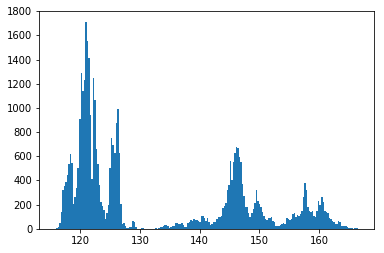

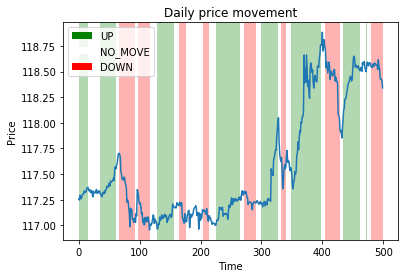

In [31]:
with gzip.GzipFile("data/kraken/eth_eur_d20_lw20_sw300_l3.npy.gz", "r") as file:
    dataset = np.load(file)
    
lob_depth = int(len(dataset["snapshot"][0])/2)

print("Dataset size:", len(dataset))
print("Depth:", lob_depth)
print()
print("Label distribution in the whole dataset:")
count_labels(dataset["label"])

plt.hist(dataset["vwap"], bins=200)
plot_labels(dataset["vwap"][:500], dataset["label"][:500], False)
plt.show()

In [ ]:
# Rescale volumes with log function to lower outliers
dataset["snapshot"][:,:,0:2] = np.log(dataset["snapshot"][:,:,0:2])

In [19]:
day = 10
window_size = 50

r = range(0, len(dataset["snapshot"])-window_size-day, day)

scalers = [StandardScaler().fit(dataset["snapshot"][i:i+window_size].reshape(-1, 3)) for i in r]

for cnt, i in enumerate(r):
    dataset["snapshot"][i+window_size:i+window_size+day] = \
    scalers[cnt].transform(dataset["snapshot"][i+window_size:i+window_size+day].reshape(-1, 3)).reshape(-1, 2*lob_depth, 3)
    
dataset = dataset[window_size:int(len(dataset)/day)*day]

In [32]:
# V = 100 * N ( 0.5( X -F50)/(F75-F25)) -50
def V(metrics, X):
    F25 = metrics["F25"]
    F50 = metrics["F50"]
    F75 = metrics["F75"]
    
    N = norm.cdf(0.5*(X-F50)/(F75-F25))
    
    return N-0.5

In [33]:
day = 10
window_size = 50

n_scaled = int(len(dataset)/day)*day-window_size

metric_dtype = [("F25", np.float32, 1), ("F50", np.float32, 1), ("F75", np.float32, 1)]

metrics = np.empty([(len(dataset)-window_size)//day], dtype=[("price", metric_dtype), ("volume", metric_dtype)])

for cnt, i in enumerate(range(0, len(dataset["snapshot"])-window_size-day, day)):
    p_history = dataset["snapshot"][i:i+window_size,:,0]
    v_history = dataset["snapshot"][i:i+window_size,:,1]
    
    metrics["price"][cnt] = (np.percentile(p_history, 25), np.percentile(p_history, 50), np.percentile(p_history, 75))
    metrics["volume"][cnt] = (np.percentile(v_history, 25), np.percentile(v_history, 50), np.percentile(v_history, 75))

for cnt, i in enumerate(range(0, len(dataset["snapshot"])-window_size-day, day)):
    X = dataset["snapshot"][i+window_size:i+window_size+day]
    
    dataset["snapshot"][i+window_size:i+window_size+day,:,0] = V(metrics[cnt]["price"], X[:,:,0])
    dataset["snapshot"][i+window_size:i+window_size+day,:,1] = V(metrics[cnt]["volume"], X[:,:,1])
    
dataset = dataset[window_size:int(len(dataset)/day)*day]

In [ ]:
idx = []
for i in range(len(dataset["snapshot"])):
    if abs(calc_VWAP(dataset["snapshot"][i].reshape(120))) < 20:
        idx.append(i)
        
dataset = dataset[idx]

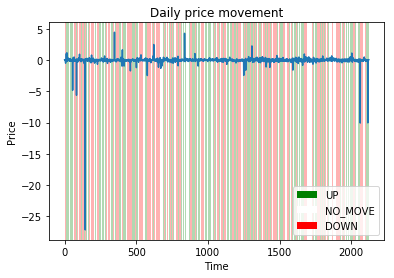

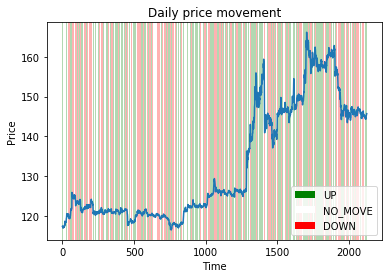

In [34]:
vwaps = [calc_VWAP(i) for i in dataset["snapshot"].reshape(-1, 2*lob_depth*3)]

plot_labels(vwaps[::20], dataset["label"][::20])
plot_labels(dataset["vwap"][::20], dataset["label"][::20])

In [35]:
# sort labels for the equalization
ups = dataset[np.where(dataset["label"] == 1)]
nomoves = dataset[np.where(dataset["label"] == 0)]
downs = dataset[np.where(dataset["label"] == -1)]

# to equalize number of labels in the dataset use the lowest number
n_samples_per_label = np.min([len(ups), len(nomoves), len(downs)])

In [36]:
# train-test split
test_split = 0.2

ups_train, ups_test         = train_test_split(ups, test_size=test_split, random_state=42, shuffle = False, stratify = None)
nomoves_train, nomoves_test = train_test_split(nomoves, test_size=test_split, random_state=42, shuffle = False, stratify = None)
downs_train, downs_test     = train_test_split(downs, test_size=test_split, random_state=42, shuffle = False, stratify = None)

In [37]:
# shuffle before selecting by the n_samples_per_label 
# (to avoid not using any data from the last section of the bigger sets)
np.random.shuffle(ups_train)
np.random.shuffle(ups_test)

np.random.shuffle(nomoves_train)
np.random.shuffle(nomoves_test)

np.random.shuffle(downs_train)
np.random.shuffle(downs_test)

In [38]:
# create the mixed train and test sets
train = np.concatenate(
     (ups_train[:int(n_samples_per_label*(1-test_split))], 
     nomoves_train[:int(n_samples_per_label*(1-test_split))], 
     downs_train[:int(n_samples_per_label*(1-test_split))])
)

test = np.concatenate(
     (ups_test[:int(n_samples_per_label*(test_split))], 
     nomoves_test[:int(n_samples_per_label*(test_split))], 
     downs_test[:int(n_samples_per_label*(test_split))])
)

In [39]:
# shuffle to mix labels
np.random.shuffle(train)
np.random.shuffle(test)

In [40]:
# input
X_train = train['snapshot'][:,:,0:1]
X_test = test['snapshot'][:,:,0:1]

# reshape (flatten)
X_train = X_train.reshape(-1, 2*lob_depth*1)
X_test = X_test.reshape(-1, 2*lob_depth*1)

# output
Y_train = train['label']
Y_test = test['label']

In [41]:
print("Train shape:", X_train.shape)
print("Label distribution in train set:")
count_labels(Y_train)

print()

print("Test shape:", X_test.shape)
print("Label distribution in test set:")
count_labels(Y_test)

Train shape: (24918, 40)
Label distribution in train set:
UP labels: 8306 	 33.33333333333333%
NO_MOVE labels: 8306 	 33.33333333333333%
DOWN labels: 8306 	 33.33333333333333%

Test shape: (6228, 40)
Label distribution in test set:
UP labels: 2076 	 33.33333333333333%
NO_MOVE labels: 2076 	 33.33333333333333%
DOWN labels: 2076 	 33.33333333333333%


# Logistic Regression

In [42]:
C = 1e-3

if n_labels == 2:
    logreg = linear_model.LogisticRegression(C=C,solver='lbfgs')
else:
    logreg = linear_model.LogisticRegression(C=C,solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=-1)

LOGISTIC REGRESSION

accuracy: 0.46130378933847144 %
precision: 0.41550125808152505 %
recall: 0.46130378933847144 %
f1_score: 0.41523847167638256 %

Confusion matrix, without normalization


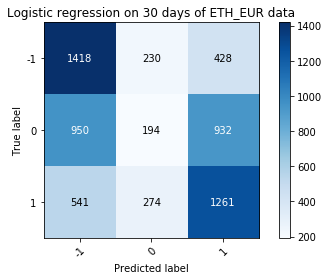

Normalized confusion matrix


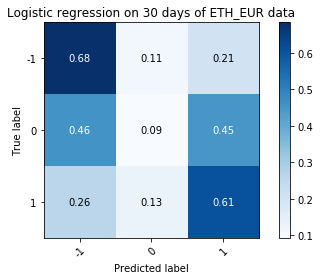

In [43]:
print("LOGISTIC REGRESSION")
logreg.fit(X_train,Y_train)

predictions = logreg.predict(X_test)

print()
metrics = evaluate_result(Y_test, predictions)
for key in metrics:
    print(key + ":", metrics[key], '%')
print()

title = 'Logistic regression on 30 days of ETH_EUR data'

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, normalize=True, title=title)

# Random Forest

In [44]:
# Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)

clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RANDOM FOREST REGRESSION

accuracy: 0.4582530507385999 %
precision: 0.4438884071467868 %
recall: 0.4582530507385999 %
f1_score: 0.44545129337669404 %

Confusion matrix, without normalization


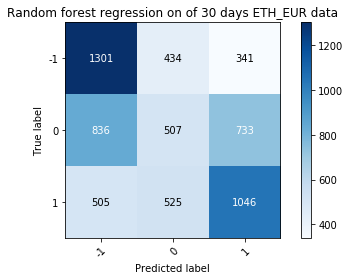

Normalized confusion matrix


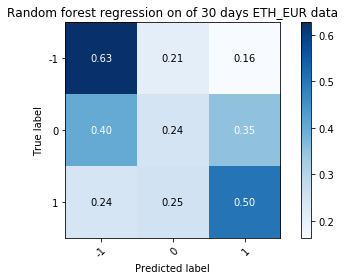

In [45]:
print("RANDOM FOREST REGRESSION")

predictions = clf.predict(X_test)

print()
metrics = evaluate_result(Y_test, predictions)
for key in metrics:
    print(key + ":", metrics[key], '%')
print()

title = 'Random forest regression on of 30 days ETH_EUR data'

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, normalize=True, title=title)

# Mean prediction baseline

We predict the movement using only the mean of historical data in a sliding window.

In [ ]:
history_len = 40
alpha = 0.9

predictions = np.zeros([len(dataset)-history_len], dtype=[("label", int, 1)])

print("BASELINE PREDICTION BASED ON HISTORICAL MEAN", "\n")

# make predictions
for i in range(len(dataset)-history_len):
    vwap = dataset["vwap"][i+history_len]
    mean = np.mean(dataset["vwap"][i:i+history_len+1])
    volatility = calc_volatility(dataset["vwap"][i:i+history_len+1])
    
    threshold = volatility * alpha
    
    if n_labels == 2:
        if mean < vwap:
            predictions[i] = 1
        else:
            predictions[i] = -1
    
    elif n_labels == 3:
        if mean - vwap < -threshold:
            predictions[i] = 1
        elif mean - vwap > threshold:
            predictions[i] = -1
        else:
            predictions[i] = 0
    else:
        raise AttributeError()

metrics = evaluate_result(dataset["label"][history_len:], predictions["label"])
for key in metrics:
    print(key + ":", metrics[key], '%')
print()
        
title = "Baseline prediction on 30 days of ETH_EUR data"      


# Plot non-normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], classes=class_names,
                      title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], classes=class_names, normalize=True,
                      title=title)